<a href="https://colab.research.google.com/github/amrzhd/EEGNet/blob/main/EEGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motor Imagery Task Classification


#Extracting Data

##Downloading BCI Competition IV 2a Dataset

In [ ]:
!conda install -n .conda ipykernel --update-deps --force-reinstall


In [ ]:
!wget https://www.bbci.de/competition/download/competition_iv/BCICIV_2a_gdf.zip

In [ ]:
!mkdir -p /root/workspace/vit/EEGNet/cleaned_data/

# 다운받은 데이터파일 압축풀고 디렉토리 형태 구성하기


In [4]:

%%capture
!unzip /root/workspace/vit/EEGNet/BCICIV_2a_gdf.zip -d raw

# BCI Competition IV 2a 데이터셋을 subject별로 정리
import os
import shutil

raw_data_dir = 'raw'
organized_data_dir = '/root/workspace/vit/EEGNet/raw_data'

# organized_data_dir 생성
os.makedirs(organized_data_dir, exist_ok=True)

# raw_data 디렉토리에서 파일들을 찾아서 subject별로 정리
if os.path.exists(raw_data_dir):
    for file in os.listdir(raw_data_dir):
        if file.endswith('.gdf'):
            # 파일명에서 subject 번호 추출 (예: A01T.gdf -> 01)
            if file.startswith('A') and len(file) >= 6:
                subject_num = file[1:3]  # A01T.gdf에서 01 추출
                subject_dir = os.path.join(organized_data_dir, f'subject{subject_num}')
                
                # subject 디렉토리 생성
                os.makedirs(subject_dir, exist_ok=True)
                
                # 파일 이동
                src_file = os.path.join(raw_data_dir, file)
                dst_file = os.path.join(subject_dir, file)
                shutil.move(src_file, dst_file)
                print(f"Moved {file} to {subject_dir}")

# 임시 raw_data 디렉토리 정리
if os.path.exists(raw_data_dir):
    shutil.rmtree(raw_data_dir)

print("Data organization completed!")
print(f"Organized data structure in: {organized_data_dir}")

# 결과 확인
for subject_folder in sorted(os.listdir(organized_data_dir)):
    subject_path = os.path.join(organized_data_dir, subject_folder)
    if os.path.isdir(subject_path):
        files = os.listdir(subject_path)
        print(f"{subject_folder}: {files}")

#Installing Packages

In [ ]:
%%capture
!pip install mne

In [ ]:
%%capture
!pip install torch-summary

In [ ]:
!pip install torch==2.3.0
!pip install torch-summary==1.4.5
!pip install mne>=0.17.1
!pip install scikit-learn>=0.20.1
!pip install matplotlib>=2.2.3

In [ ]:
!pip install gdown pandas scikit-learn matplotlib seaborn

#Libraries Used

In [5]:
import os
import mne
import math
import copy
import gdown
import random
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, random_split

# Scikit-Learn
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Building Dataset

In [ ]:
!mkdir -p /root/workspace/vit/EEGNet/cleaned_data/first_session
!mkdir -p /root/workspace/vit/EEGNet/cleaned_data/second_session

##First Session

In [6]:
raw_data_folder = '/root/workspace/vit/EEGNet/raw_data'
cleaned_data_folder = '/root/workspace/vit/EEGNet/cleaned_data/first_session/'

# Create cleaned_data folder if it doesn't exist
os.makedirs(cleaned_data_folder, exist_ok=True)

# Get all subject folders
subject_folders = [f for f in os.listdir(raw_data_folder) if os.path.isdir(os.path.join(raw_data_folder, f))]

raw_list = []

# Iterating through subject folders
for subject_folder in subject_folders:
    subject_path = os.path.join(raw_data_folder, subject_folder)
    files = os.listdir(subject_path)
    
    # Find T.gdf file in this subject folder
    t_files = [file for file in files if file.endswith('T.gdf')]
    
    for file in t_files:
        file_path = os.path.join(subject_path, file)
        print(f"Processing: {file_path}")

        # Reading raw data
        raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)
        # Droping EOG channels
        raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

        # High Pass Filtering 4-40 Hz
        raw.filter(l_freq=4, h_freq=40, method='iir')

        # Notch filter for Removal of Line Voltage
        raw.notch_filter(freqs=50)

        # Saving the modified raw data to a file with .fif suffix
        new_file_path = os.path.join(cleaned_data_folder, f"{subject_folder}_{file[:-4]}.fif")
        raw.save(new_file_path, overwrite=True)
        # Appending data to the list
        raw_list.append(raw)

# Check if we found any files
if len(raw_list) == 0:
    print("No T.gdf files found!")
    print(f"Checked folders: {subject_folders}")
else:
    print(f"Found {len(raw_list)} T.gdf files")
    final_raw = mne.concatenate_raws(raw_list)
    new_file_path = os.path.join(cleaned_data_folder, 'First_Session_Subjects.fif')
    final_raw.save(new_file_path, overwrite=True)

Processing: /root/workspace/vit/EEGNet/raw_data/subject08/A08T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject08/A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 675269  =      0.000 ...  2701.076 secs...
Reading 0 ... 675269  =      0.000 ...  2701.076 secs...


/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_12990/3307086155.py:37: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/first_session/subject08_A08T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/first_session/subject08_A08T.fif
[done]
Processing: /root/workspace/vit/EEGNet/raw_data/subject02/A02T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject02/A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 677168  =      0.000 ...  2708.672 secs...
[done]
Processing: /root/workspace/vit/EEGNet/raw_data/subject02/A02T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject02/A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, 

/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_12990/3307086155.py:37: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/first_session/subject02_A02T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/first_session/subject02_A02T.fif
[done]
Processing: /root/workspace/vit/EEGNet/raw_data/subject09/A09T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject09/A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 673327  =      0.000 ...  2693.308 secs...
[done]
Processing: /root/workspace/vit/EEGNet/raw_data/subject09/A09T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject09/A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, 

/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_12990/3307086155.py:37: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/first_session/subject09_A09T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/first_session/subject09_A09T.fif
[done]
Processing: /root/workspace/vit/EEGNet/raw_data/subject07/A07T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject07/A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 681070  =      0.000 ...  2724.280 secs...
[done]
Processing: /root/workspace/vit/EEGNet/raw_data/subject07/A07T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject07/A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, 

/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_12990/3307086155.py:37: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/first_session/subject07_A07T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/first_session/subject07_A07T.fif
[done]
Processing: /root/workspace/vit/EEGNet/raw_data/subject05/A05T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject05/A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 686119  =      0.000 ...  2744.476 secs...
[done]
Processing: /root/workspace/vit/EEGNet/raw_data/subject05/A05T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject05/A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, 

/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_12990/3307086155.py:37: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/first_session/subject05_A05T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/first_session/subject05_A05T.fif
[done]
Processing: /root/workspace/vit/EEGNet/raw_data/subject03/A03T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject03/A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 660529  =      0.000 ...  2642.116 secs...
[done]
Processing: /root/workspace/vit/EEGNet/raw_data/subject03/A03T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject03/A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, 

/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_12990/3307086155.py:37: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/first_session/subject03_A03T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/first_session/subject03_A03T.fif
[done]
Processing: /root/workspace/vit/EEGNet/raw_data/subject01/A01T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject01/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...
[done]
Processing: /root/workspace/vit/EEGNet/raw_data/subject01/A01T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject01/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, 

/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_12990/3307086155.py:37: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/first_session/subject01_A01T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/first_session/subject01_A01T.fif
[done]
Processing: /root/workspace/vit/EEGNet/raw_data/subject06/A06T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject06/A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 678979  =      0.000 ...  2715.916 secs...
[done]
Processing: /root/workspace/vit/EEGNet/raw_data/subject06/A06T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject06/A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, 

/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_12990/3307086155.py:37: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/first_session/subject06_A06T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/first_session/subject06_A06T.fif
[done]
Processing: /root/workspace/vit/EEGNet/raw_data/subject04/A04T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject04/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...
[done]
Processing: /root/workspace/vit/EEGNet/raw_data/subject04/A04T.gdf
Extracting EDF parameters from /root/workspace/vit/EEGNet/raw_data/subject04/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, 

/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_12990/3307086155.py:37: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/first_session/subject04_A04T.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/first_session/subject04_A04T.fif
[done]
[done]
Found 9 T.gdf files
Found 9 T.gdf files
Overwriting existing file.
Writing /root/workspace/vit/EEGNet/cleaned_data/first_session/First_Session_Subjects.fif
Overwriting existing file.
Writing /root/workspace/vit/EEGNet/cleaned_data/first_session/First_Session_Subjects.fif


/tmp/ipykernel_12990/3307086155.py:49: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/first_session/First_Session_Subjects.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  final_raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/first_session/First_Session_Subjects.fif
[done]
[done]


**List of the events**  
'1023': 1 Rejected trial  
'1072': 2 Eye movements  
'276': 3 Idling EEG (eyes open)  
'277': 4 Idling EEG (eyes closed)  
'32766': 5 Start of a new run  
'768': 6 Start of a trial  
'769': 7 Cue onset **Left** (class 1) : 0  
'770': 8 Cue onset **Right** (class 2) : 1  
'771': 9 Cue onset **Foot** (class 3) : 2  
'772': 10 Cue onset **Tongue** (class 4): 3

In [4]:
events = mne.events_from_annotations(final_raw)
events[1]

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


{'1023': 1,
 '1072': 2,
 '276': 3,
 '277': 4,
 '32766': 5,
 '768': 6,
 '769': 7,
 '770': 8,
 '771': 9,
 '772': 10}

**Time choice:**  
[0.s, 4s] Post Cue on set:  [2s, 6s]

In [5]:
epochs = mne.Epochs(final_raw, events[0], event_id=[7, 8, 9, 10], tmin=0, tmax=4, reject=None, baseline=None, preload=True)
first_session_data = epochs.get_data(copy=True)
first_session_labels = epochs.events[:,-1]

Not setting metadata
2592 matching events found
2592 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2592 events and 1001 original time points ...
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2592 events and 1001 original time points ...
0 bad epochs dropped
0 bad epochs dropped


In [6]:
print("First_session_dataset shape:",first_session_data.shape)

First_session_dataset shape: (2592, 22, 1001)


##Second Session

###Extracting Labels for datas with "E.gdf" prefix

In [7]:
# Replace this with your actual shareable link
shareable_link = 'https://drive.google.com/file/d/11Ke2Xta1kv2xu2Mybuu_X51zJYjQ-VFo/view?usp=drive_link'

# Extract file ID from the shareable link
file_id = shareable_link.split('/d/')[1].split('/view')[0]

# Create the direct download link
download_url = f'https://drive.google.com/uc?id={file_id}&export=download'

# Specify the output file path
output_file = 'true_labels.zip'

# Download the file
gdown.download(download_url, output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=11Ke2Xta1kv2xu2Mybuu_X51zJYjQ-VFo&export=download
To: /root/workspace/vit/EEGNet/true_labels.zip
100%|██████████| 7.20k/7.20k [00:00<00:00, 607kB/s]
100%|██████████| 7.20k/7.20k [00:00<00:00, 607kB/s]


'true_labels.zip'

In [ ]:

!unzip /root/workspace/vit/EEGNet/true_labels.zip -d second_session_labels

###Extracting datas of second session

In [ ]:
raw_data_folder = '/root/workspace/vit/EEGNet/raw_data'
cleaned_data_folder = '/root/workspace/vit/EEGNet/cleaned_data/second_session/'
mat_folder = '/root/workspace/vit/EEGNet/second_session_labels/'

# Create cleaned_data folder if it doesn't exist
os.makedirs(cleaned_data_folder, exist_ok=True)

# Get all subject folders
subject_folders = [f for f in os.listdir(raw_data_folder) if os.path.isdir(os.path.join(raw_data_folder, f))]

# Selecting files with suffix 'E.gdf'
raw_list = []
second_session_labels = np.array([])

# Iterating through subject folders to find E.gdf files
for subject_folder in subject_folders:
    subject_path = os.path.join(raw_data_folder, subject_folder)
    files = os.listdir(subject_path)
    
    # Find E.gdf file in this subject folder
    e_files = [file for file in files if file.endswith('E.gdf')]
    
    for file in e_files:
        file_path = os.path.join(subject_path, file)
        print(f"Processing: {file_path}")

        # Reading raw data
        raw = mne.io.read_raw_gdf(file_path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)
        # Droping EOG channels
        raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

        # High Pass Filtering 4-40 Hz
        raw.filter(l_freq=4, h_freq=40, method='iir')

        # Notch filter for Removal of Line Voltage
        raw.notch_filter(freqs=50)

        # Saving the modified raw data to a file with .fif suffix
        new_file_path = os.path.join(cleaned_data_folder, f"{subject_folder}_{file[:-4]}.fif")
        raw.save(new_file_path, overwrite=True)
        # Appending data to the list
        raw_list.append(raw)

        # Mat files for the labels
        mat_file_name = file.replace('.gdf', '.mat')
        mat_file_path = os.path.join(mat_folder, mat_file_name)
        print(f"data:{file}, label:{mat_file_name}")

        if os.path.exists(mat_file_path):
            mat_data = scipy.io.loadmat(mat_file_path)
            class_labels = mat_data.get('classlabel', [])

            # Check if 'classlabel' key exists and is not empty
            if class_labels.size > 0:
                 # Convert to a NumPy array and flatten
                class_labels_array = np.array(class_labels, dtype=int).flatten()
                # Concatenate with the existing test_labels array
                second_session_labels = np.concatenate((second_session_labels, class_labels_array))
            else:
                print(f"Warning: 'classlabel' not found or empty in {mat_file_name}.")
        else:
            print(f"Warning: {mat_file_name} not found.")

# Check if we found any files
if len(raw_list) == 0:
    print("No E.gdf files found!")
    print(f"Checked folders: {subject_folders}")
else:
    print(f"Found {len(raw_list)} E.gdf files")
    final_raw = mne.concatenate_raws(raw_list)
    new_file_path = os.path.join(cleaned_data_folder, 'Second_Session_Subjects.fif')
    final_raw.save(new_file_path, overwrite=True)

Processing: /root/workspace/vit/data/raw/subject08/A08E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject08/A08E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 687791  =      0.000 ...  2751.164 secs...
Creating raw.info structure...
Reading 0 ... 687791  =      0.000 ...  2751.164 secs...


/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_6537/3243016851.py:40: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/second_session/subject08_A08E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/second_session/subject08_A08E.fif
[done]
data:A08E.gdf, label:A08E.mat
Processing: /root/workspace/vit/data/raw/subject02/A02E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject02/A02E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 662665  =      0.000 ...  2650.660 secs...
[done]
data:A08E.gdf, label:A08E.mat
Processing: /root/workspace/vit/data/raw/subject02/A02E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject02/A02E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EE

/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_6537/3243016851.py:40: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/second_session/subject02_A02E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/second_session/subject02_A02E.fif
[done]
data:A02E.gdf, label:A02E.mat
Processing: /root/workspace/vit/data/raw/subject09/A09E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject09/A09E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 675097  =      0.000 ...  2700.388 secs...
[done]
data:A02E.gdf, label:A02E.mat
Processing: /root/workspace/vit/data/raw/subject09/A09E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject09/A09E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EE

/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_6537/3243016851.py:40: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/second_session/subject09_A09E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/second_session/subject09_A09E.fif
[done]
data:A09E.gdf, label:A09E.mat
Processing: /root/workspace/vit/data/raw/subject07/A07E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject07/A07E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 673134  =      0.000 ...  2692.536 secs...
[done]
data:A09E.gdf, label:A09E.mat
Processing: /root/workspace/vit/data/raw/subject07/A07E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject07/A07E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EE

/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_6537/3243016851.py:40: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/second_session/subject07_A07E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/second_session/subject07_A07E.fif
[done]
data:A07E.gdf, label:A07E.mat
Processing: /root/workspace/vit/data/raw/subject05/A05E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject05/A05E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 679862  =      0.000 ...  2719.448 secs...
[done]
data:A07E.gdf, label:A07E.mat
Processing: /root/workspace/vit/data/raw/subject05/A05E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject05/A05E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EE

/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_6537/3243016851.py:40: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/second_session/subject05_A05E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/second_session/subject05_A05E.fif
[done]
data:A05E.gdf, label:A05E.mat
Processing: /root/workspace/vit/data/raw/subject03/A03E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject03/A03E.gdf...
GDF file detected
[done]
data:A05E.gdf, label:A05E.mat
Processing: /root/workspace/vit/data/raw/subject03/A03E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject03/A03E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 648774  =      0.000 ...  2595.096 secs...
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EE

/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_6537/3243016851.py:40: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/second_session/subject03_A03E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/second_session/subject03_A03E.fif
[done]
data:A03E.gdf, label:A03E.mat
Processing: /root/workspace/vit/data/raw/subject01/A01E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject01/A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 686999  =      0.000 ...  2747.996 secs...
[done]
data:A03E.gdf, label:A03E.mat
Processing: /root/workspace/vit/data/raw/subject01/A01E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject01/A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EE

/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_6537/3243016851.py:40: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/second_session/subject01_A01E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/second_session/subject01_A01E.fif
[done]
data:A01E.gdf, label:A01E.mat
Processing: /root/workspace/vit/data/raw/subject06/A06E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject06/A06E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 666372  =      0.000 ...  2665.488 secs...
[done]
data:A01E.gdf, label:A01E.mat
Processing: /root/workspace/vit/data/raw/subject06/A06E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject06/A06E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EE

/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_6537/3243016851.py:40: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/second_session/subject06_A06E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/second_session/subject06_A06E.fif
[done]
data:A06E.gdf, label:A06E.mat
Processing: /root/workspace/vit/data/raw/subject04/A04E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject04/A04E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 660046  =      0.000 ...  2640.184 secs...
[done]
data:A06E.gdf, label:A06E.mat
Processing: /root/workspace/vit/data/raw/subject04/A04E.gdf
Extracting EDF parameters from /root/workspace/vit/data/raw/subject04/A04E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EE

/root/miniconda3/envs/eegnet/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_6537/3243016851.py:40: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/second_session/subject04_A04E.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/second_session/subject04_A04E.fif
[done]
[done]
data:A04E.gdf, label:A04E.mat
Found 9 E.gdf files
data:A04E.gdf, label:A04E.mat
Found 9 E.gdf files
Overwriting existing file.
Writing /root/workspace/vit/EEGNet/cleaned_data/second_session/Second_Session_Subjects.fif
Overwriting existing file.
Writing /root/workspace/vit/EEGNet/cleaned_data/second_session/Second_Session_Subjects.fif


/tmp/ipykernel_6537/3243016851.py:72: RuntimeWarning: This filename (/root/workspace/vit/EEGNet/cleaned_data/second_session/Second_Session_Subjects.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  final_raw.save(new_file_path, overwrite=True)


Closing /root/workspace/vit/EEGNet/cleaned_data/second_session/Second_Session_Subjects.fif
[done]
[done]


**List of the events**  
'1023': 1 Rejected trial  
'1072': 2 Eye movements  
'276': 3 Idling EEG (eyes open)  
'277': 4 Idling EEG (eyes closed)  
'32766': 5 Start of a new run  
'768': 6 Start of a trial  
'783': 7 Cue unknown

In [9]:
events = mne.events_from_annotations(final_raw)
events[1]

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']


{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '783': 7}

In [10]:
epochs = mne.Epochs(final_raw, events[0], event_id=7, tmin=0, tmax=4, reject=None, baseline=None, preload=None)
second_session_data = epochs.get_data(copy=True)

Not setting metadata
2592 matching events found
No baseline correction applied
0 projection items activated
2592 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2592 events and 1001 original time points ...
Using data from preloaded Raw for 2592 events and 1001 original time points ...
0 bad epochs dropped
0 bad epochs dropped


In [11]:
print("Second Session Dataset shape:",second_session_data.shape)

Second Session Dataset shape: (2592, 22, 1001)


###Structuring Data

In [12]:
# Choosing Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss Function
criterion = nn.CrossEntropyLoss()

# Normalizing Labels to [0, 1, 2, 3]
y_train = first_session_labels - np.min(first_session_labels)
y_test = second_session_labels - np.min(second_session_labels)

# Normalizing Input features: z-score(mean=0, std=1)
X_first_session = (first_session_data - np.mean(first_session_data)) / np.std(first_session_data)
X_second_session = (second_session_data - np.mean(second_session_data)) / np.std(second_session_data)

X = np.concatenate((X_first_session, X_second_session))
y = np.concatenate((y_train, y_test))

# Spliting  Data: 90% for Train and 10% for Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Converting to Tensor
X_train = torch.Tensor(X_train).unsqueeze(1).to(device)
X_test = torch.Tensor(X_test).unsqueeze(1).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

# Creating Tensor Dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Printing the sizes
print("Size of X_train:", X_train.size())
print("Size of X_test:", X_test.size())
print("Size of y_train:", y_train.size())
print("Size of y_test:", y_test.size())


Size of X_train: torch.Size([4665, 1, 22, 1001])
Size of X_test: torch.Size([519, 1, 22, 1001])
Size of y_train: torch.Size([4665])
Size of y_test: torch.Size([519])


#Evaluating Model

In [ ]:
class EvalModel():
    def __init__(self, model):
        self.model = model.to(device)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def test_model(self, test_dataset):
        self.model.eval()
        correct = 0
        total = 0
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = (correct / total) * 100
        print("/------------------------------/")
        print(f"Test Accuracy: {accuracy:.2f}%")
        print("/------------------------------/")
        return accuracy

    def plot_confusion_matrix(self, test_dataset, classes):
        self.model.eval()
        y_pred = []
        y_true = []
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                y_pred.append(predicted.item())
                y_true.append(labels.item())

        cf_matrix = confusion_matrix(y_true, y_pred)
        cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

        df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)

        plt.figure(figsize=(10, 7))
        sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix_model.png')
        plt.show()


#EEGNet Model

In [ ]:
class EEGNetModel(nn.Module): # EEGNET-8,2
    def __init__(self, chans=22, classes=4, time_points=1001, temp_kernel=32,
                 f1=16, f2=32, d=2, pk1=8, pk2=16, dropout_rate=0.5, max_norm1=1, max_norm2=0.25):
        super(EEGNetModel, self).__init__()
        # Calculating FC input features
        linear_size = (time_points//(pk1*pk2))*f2

        # Temporal Filters
        self.block1 = nn.Sequential(
            nn.Conv2d(1, f1, (1, temp_kernel), padding='same', bias=False),
            nn.BatchNorm2d(f1),
        )
        # Spatial Filters
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, d * f1, (chans, 1), groups=f1, bias=False), # Depthwise Conv
            nn.BatchNorm2d(d * f1),
            nn.ELU(),
            nn.AvgPool2d((1, pk1)),
            nn.Dropout(dropout_rate)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(d * f1, f2, (1, 16),  groups=f2, bias=False, padding='same'), # Separable Conv
            nn.Conv2d(f2, f2, kernel_size=1, bias=False), # Pointwise Conv
            nn.BatchNorm2d(f2),
            nn.ELU(),
            nn.AvgPool2d((1, pk2)),
            nn.Dropout(dropout_rate)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(linear_size, classes)

        # Apply max_norm constraint to the depthwise layer in block2
        self._apply_max_norm(self.block2[0], max_norm1)

        # Apply max_norm constraint to the linear layer
        self._apply_max_norm(self.fc, max_norm2)

    def _apply_max_norm(self, layer, max_norm):
        for name, param in layer.named_parameters():
            if 'weight' in name:
                param.data = torch.renorm(param.data, p=2, dim=0, maxnorm=max_norm)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


##Model Summery

In [ ]:
input_size = (1, 22, 1001)
eegnet_model = EEGNetModel().to(device)
summary(eegnet_model, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 22, 1001]        --
|    └─Conv2d: 2-1                       [-1, 16, 22, 1001]        512
|    └─BatchNorm2d: 2-2                  [-1, 16, 22, 1001]        32
├─Sequential: 1-2                        [-1, 32, 1, 125]          --
|    └─Conv2d: 2-3                       [-1, 32, 1, 1001]         704
|    └─BatchNorm2d: 2-4                  [-1, 32, 1, 1001]         64
|    └─ELU: 2-5                          [-1, 32, 1, 1001]         --
|    └─AvgPool2d: 2-6                    [-1, 32, 1, 125]          --
|    └─Dropout: 2-7                      [-1, 32, 1, 125]          --
├─Sequential: 1-3                        [-1, 32, 1, 7]            --
|    └─Conv2d: 2-8                       [-1, 32, 1, 125]          512
|    └─Conv2d: 2-9                       [-1, 32, 1, 125]          1,024
|    └─BatchNorm2d: 2-10                 [-1, 32, 1, 125]          64
|    └─EL

/root/miniconda3/envs/eegnet/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 22, 1001]        --
|    └─Conv2d: 2-1                       [-1, 16, 22, 1001]        512
|    └─BatchNorm2d: 2-2                  [-1, 16, 22, 1001]        32
├─Sequential: 1-2                        [-1, 32, 1, 125]          --
|    └─Conv2d: 2-3                       [-1, 32, 1, 1001]         704
|    └─BatchNorm2d: 2-4                  [-1, 32, 1, 1001]         64
|    └─ELU: 2-5                          [-1, 32, 1, 1001]         --
|    └─AvgPool2d: 2-6                    [-1, 32, 1, 125]          --
|    └─Dropout: 2-7                      [-1, 32, 1, 125]          --
├─Sequential: 1-3                        [-1, 32, 1, 7]            --
|    └─Conv2d: 2-8                       [-1, 32, 1, 125]          512
|    └─Conv2d: 2-9                       [-1, 32, 1, 125]          1,024
|    └─BatchNorm2d: 2-10                 [-1, 32, 1, 125]          64
|    └─EL

#Training Class

# val 0


In [13]:
class TrainModel():
    def __init__(self,):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train_model(self, model, train_dataset, validation_split=0.2, learning_rate=0.001, batch_size=64, epochs=500):
        model = model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Split training data into train and validation
        train_size = int((1 - validation_split) * len(train_dataset))
        val_size = len(train_dataset) - train_size
        train_data, val_data = random_split(train_dataset, [train_size, val_size])
        
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
        
        # 러닝 커브를 위한 리스트들
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        epochs_list = []
        
        highest_train_accuracy = 0.0
        highest_val_accuracy = 0.0
        
        # 실시간 플롯 설정
        plt.ion()  # 인터랙티브 모드 켜기
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        for epoch in range(epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_train_loss = running_loss / len(train_data)
            epoch_train_accuracy = correct / total
            
            # Validation phase
            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    val_running_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            epoch_val_loss = val_running_loss / len(val_data)
            epoch_val_accuracy = val_correct / val_total
            
            # 최고 정확도 업데이트
            if epoch_train_accuracy > highest_train_accuracy:
                highest_train_accuracy = epoch_train_accuracy
            if epoch_val_accuracy > highest_val_accuracy:
                highest_val_accuracy = epoch_val_accuracy
            
            # 리스트에 추가
            train_losses.append(epoch_train_loss)
            train_accuracies.append(epoch_train_accuracy)
            val_losses.append(epoch_val_loss)
            val_accuracies.append(epoch_val_accuracy)
            epochs_list.append(epoch + 1)
            
            # 10 에포크마다 출력 및 플롯 업데이트
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}")
                print(f"  Train - Loss: {epoch_train_loss:.4f}, Accuracy: {(epoch_train_accuracy*100):.2f}%")
                print(f"  Val   - Loss: {epoch_val_loss:.4f}, Accuracy: {(epoch_val_accuracy*100):.2f}%")
                print("-" * 60)
                
                # 플롯 업데이트
                ax1.clear()
                ax2.clear()
                
                # Loss 플롯
                ax1.plot(epochs_list, train_losses, 'b-', label='Train Loss', linewidth=2)
                ax1.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2)
                ax1.set_xlabel('Epoch')
                ax1.set_ylabel('Loss')
                ax1.set_title('Training and Validation Loss')
                ax1.legend()
                ax1.grid(True, alpha=0.3)
                
                # Accuracy 플롯
                ax2.plot(epochs_list, [acc*100 for acc in train_accuracies], 'b-', label='Train Accuracy', linewidth=2)
                ax2.plot(epochs_list, [acc*100 for acc in val_accuracies], 'r-', label='Validation Accuracy', linewidth=2)
                ax2.set_xlabel('Epoch')
                ax2.set_ylabel('Accuracy (%)')
                ax2.set_title('Training and Validation Accuracy')
                ax2.legend()
                ax2.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.draw()
                plt.pause(0.01)

        plt.ioff()  # 인터랙티브 모드 끄기
        plt.show()
        
        print("\n" + "="*60)
        print("TRAINING COMPLETED!")
        print("="*60)
        print(f"Highest Train Accuracy: {highest_train_accuracy*100:.2f}%")
        print(f"Highest Validation Accuracy: {highest_val_accuracy*100:.2f}%")
        print(f"Final Train Loss: {train_losses[-1]:.4f}")
        print(f"Final Validation Loss: {val_losses[-1]:.4f}")

        # 모델 저장
        torch.save(model.state_dict(), 'eegnet_model.pth')
        
        # 결과를 딕셔너리로 반환
        training_history = {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'epochs': epochs_list
        }
        
        return model, training_history

##Training Model

# val O (validation 사용)

Epoch 10/500
  Train - Loss: 1.1707, Accuracy: 46.52%
  Val   - Loss: 1.1421, Accuracy: 51.55%
------------------------------------------------------------


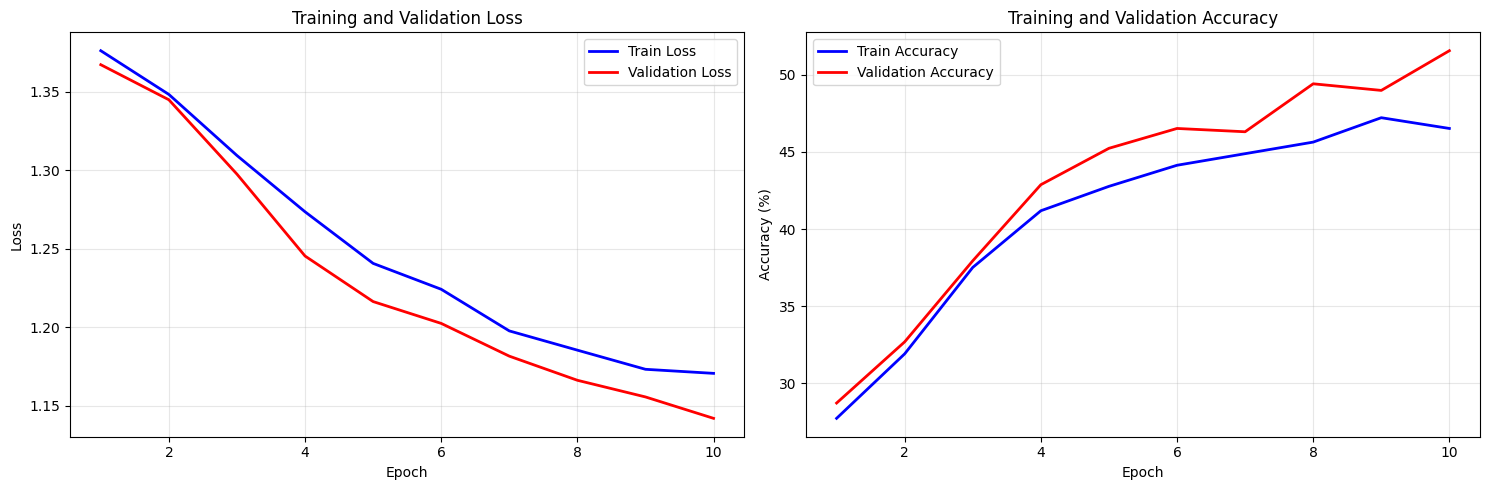

Epoch 20/500
  Train - Loss: 1.1151, Accuracy: 50.35%
  Val   - Loss: 1.0863, Accuracy: 54.02%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 30/500
  Train - Loss: 1.0793, Accuracy: 52.49%
  Val   - Loss: 1.0452, Accuracy: 56.38%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 40/500
  Train - Loss: 1.0412, Accuracy: 54.10%
  Val   - Loss: 1.0357, Accuracy: 56.48%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 50/500
  Train - Loss: 1.0244, Accuracy: 54.98%
  Val   - Loss: 1.0318, Accuracy: 54.88%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 60/500
  Train - Loss: 1.0022, Accuracy: 56.38%
  Val   - Loss: 0.9984, Accuracy: 57.23%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 70/500
  Train - Loss: 0.9767, Accuracy: 58.28%
  Val   - Loss: 0.9821, Accuracy: 59.16%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 80/500
  Train - Loss: 0.9800, Accuracy: 57.82%
  Val   - Loss: 0.9703, Accuracy: 59.49%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 90/500
  Train - Loss: 0.9543, Accuracy: 59.49%
  Val   - Loss: 0.9958, Accuracy: 57.66%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 100/500
  Train - Loss: 0.9293, Accuracy: 60.40%
  Val   - Loss: 0.9719, Accuracy: 58.74%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 110/500
  Train - Loss: 0.9345, Accuracy: 60.29%
  Val   - Loss: 0.9746, Accuracy: 58.95%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 120/500
  Train - Loss: 0.9306, Accuracy: 60.13%
  Val   - Loss: 0.9467, Accuracy: 61.09%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 130/500
  Train - Loss: 0.9248, Accuracy: 61.07%
  Val   - Loss: 0.9514, Accuracy: 61.31%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 140/500
  Train - Loss: 0.8955, Accuracy: 62.38%
  Val   - Loss: 0.9673, Accuracy: 59.81%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 150/500
  Train - Loss: 0.8939, Accuracy: 61.95%
  Val   - Loss: 0.9533, Accuracy: 60.24%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 160/500
  Train - Loss: 0.9017, Accuracy: 62.92%
  Val   - Loss: 0.9093, Accuracy: 62.49%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 170/500
  Train - Loss: 0.8918, Accuracy: 62.89%
  Val   - Loss: 0.9252, Accuracy: 61.52%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 180/500
  Train - Loss: 0.8816, Accuracy: 63.59%
  Val   - Loss: 0.9503, Accuracy: 59.49%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 190/500
  Train - Loss: 0.8698, Accuracy: 63.77%
  Val   - Loss: 0.9633, Accuracy: 60.45%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 200/500
  Train - Loss: 0.8673, Accuracy: 63.83%
  Val   - Loss: 0.8987, Accuracy: 63.67%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 210/500
  Train - Loss: 0.8864, Accuracy: 63.21%
  Val   - Loss: 0.8917, Accuracy: 64.42%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 220/500
  Train - Loss: 0.8595, Accuracy: 64.42%
  Val   - Loss: 0.8974, Accuracy: 63.45%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 230/500
  Train - Loss: 0.8618, Accuracy: 65.35%
  Val   - Loss: 0.9138, Accuracy: 62.27%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 240/500
  Train - Loss: 0.8495, Accuracy: 65.27%
  Val   - Loss: 0.8962, Accuracy: 63.67%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 250/500
  Train - Loss: 0.8533, Accuracy: 65.06%
  Val   - Loss: 0.8987, Accuracy: 63.34%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 260/500
  Train - Loss: 0.8420, Accuracy: 65.65%
  Val   - Loss: 0.8863, Accuracy: 65.06%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 270/500
  Train - Loss: 0.8408, Accuracy: 65.89%
  Val   - Loss: 0.9170, Accuracy: 62.06%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 280/500
  Train - Loss: 0.8438, Accuracy: 65.78%
  Val   - Loss: 0.9130, Accuracy: 62.38%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 290/500
  Train - Loss: 0.8359, Accuracy: 65.73%
  Val   - Loss: 0.8638, Accuracy: 67.42%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 300/500
  Train - Loss: 0.8186, Accuracy: 65.27%
  Val   - Loss: 0.8761, Accuracy: 65.06%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 310/500
  Train - Loss: 0.8170, Accuracy: 67.79%
  Val   - Loss: 0.8502, Accuracy: 66.77%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 320/500
  Train - Loss: 0.8098, Accuracy: 66.75%
  Val   - Loss: 0.8889, Accuracy: 64.42%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 330/500
  Train - Loss: 0.8220, Accuracy: 66.72%
  Val   - Loss: 0.8528, Accuracy: 66.67%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 340/500
  Train - Loss: 0.8135, Accuracy: 66.93%
  Val   - Loss: 0.8809, Accuracy: 65.38%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 350/500
  Train - Loss: 0.8075, Accuracy: 67.15%
  Val   - Loss: 0.8477, Accuracy: 66.45%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 360/500
  Train - Loss: 0.8094, Accuracy: 66.83%
  Val   - Loss: 0.8783, Accuracy: 64.20%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 370/500
  Train - Loss: 0.8028, Accuracy: 67.52%
  Val   - Loss: 0.8394, Accuracy: 66.77%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 380/500
  Train - Loss: 0.7971, Accuracy: 67.85%
  Val   - Loss: 0.8435, Accuracy: 66.88%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 390/500
  Train - Loss: 0.8075, Accuracy: 68.30%
  Val   - Loss: 0.8394, Accuracy: 67.74%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 400/500
  Train - Loss: 0.7965, Accuracy: 67.90%
  Val   - Loss: 0.8524, Accuracy: 65.59%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 410/500
  Train - Loss: 0.7991, Accuracy: 67.63%
  Val   - Loss: 0.8395, Accuracy: 67.10%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 420/500
  Train - Loss: 0.7834, Accuracy: 69.13%
  Val   - Loss: 0.8514, Accuracy: 66.02%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 430/500
  Train - Loss: 0.7885, Accuracy: 67.93%
  Val   - Loss: 0.8553, Accuracy: 65.27%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 440/500
  Train - Loss: 0.7747, Accuracy: 69.05%
  Val   - Loss: 0.8510, Accuracy: 66.24%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 450/500
  Train - Loss: 0.7802, Accuracy: 67.93%
  Val   - Loss: 0.8588, Accuracy: 65.81%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 460/500
  Train - Loss: 0.7918, Accuracy: 68.25%
  Val   - Loss: 0.8773, Accuracy: 65.38%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 470/500
  Train - Loss: 0.7684, Accuracy: 68.73%
  Val   - Loss: 0.9002, Accuracy: 65.27%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 480/500
  Train - Loss: 0.7739, Accuracy: 67.98%
  Val   - Loss: 0.8349, Accuracy: 66.35%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 490/500
  Train - Loss: 0.7786, Accuracy: 69.64%
  Val   - Loss: 0.8172, Accuracy: 69.02%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

Epoch 500/500
  Train - Loss: 0.7543, Accuracy: 70.42%
  Val   - Loss: 0.8384, Accuracy: 66.88%
------------------------------------------------------------


<Figure size 640x480 with 0 Axes>


TRAINING COMPLETED!
Highest Train Accuracy: 70.42%
Highest Validation Accuracy: 69.02%
Final Train Loss: 0.7543
Final Validation Loss: 0.8384


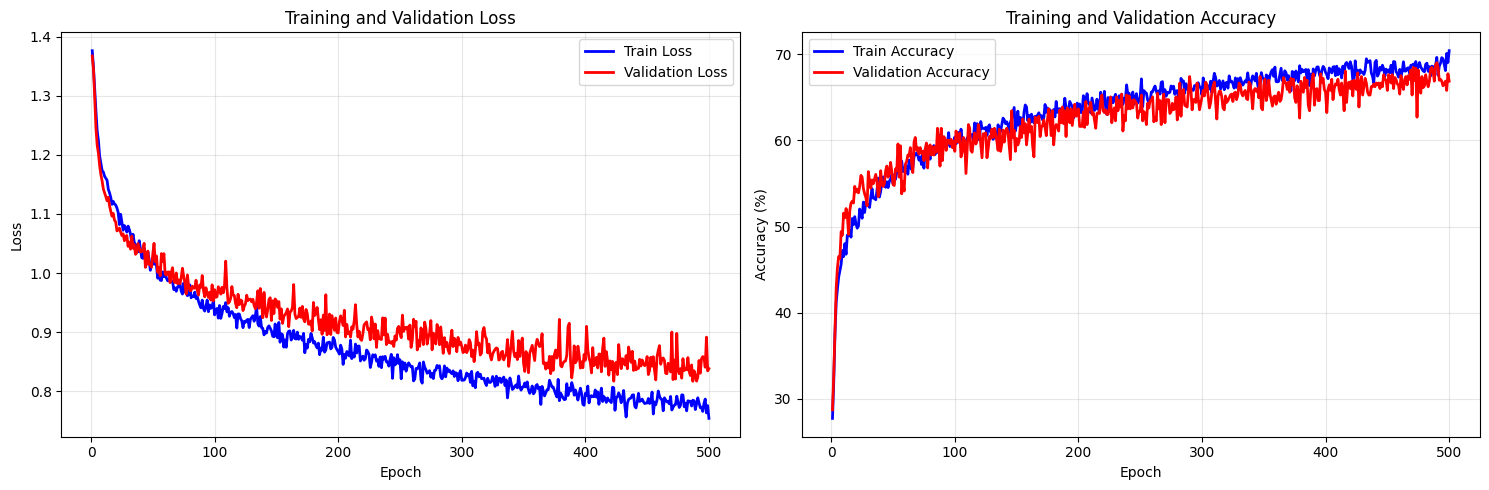

In [ ]:
eegnet_model_val = EEGNetModel().to(device)

# Training Hyperparameters with validation
EPOCHS = 500
BATCH_SIZE = 64
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2

trainer_val = TrainModel()
trained_eegnet_model_val, history_val = trainer_val.train_model(
    eegnet_model_val, 
    train_dataset, 
    validation_split=VALIDATION_SPLIT,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS
)

torch.save(trained_eegnet_model_val.state_dict(), 'eegnet_model_with_validation.pth')

# 최종 러닝 커브 저장 (train과 validation 모두)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_val['epochs'], history_val['train_losses'], 'b-', label='Train Loss', linewidth=2)
plt.plot(history_val['epochs'], history_val['val_losses'], 'r-', label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_val['epochs'], [acc*100 for acc in history_val['train_accuracies']], 'b-', label='Train Accuracy', linewidth=2)
plt.plot(history_val['epochs'], [acc*100 for acc in history_val['val_accuracies']], 'r-', label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('learning_curves_with_validation.png', dpi=300, bbox_inches='tight')
plt.show()

# Evaluating Model (with validation)

/------------------------------/
Test Accuracy: 68.79%
/------------------------------/
Test accuracy with validation: 68.79%


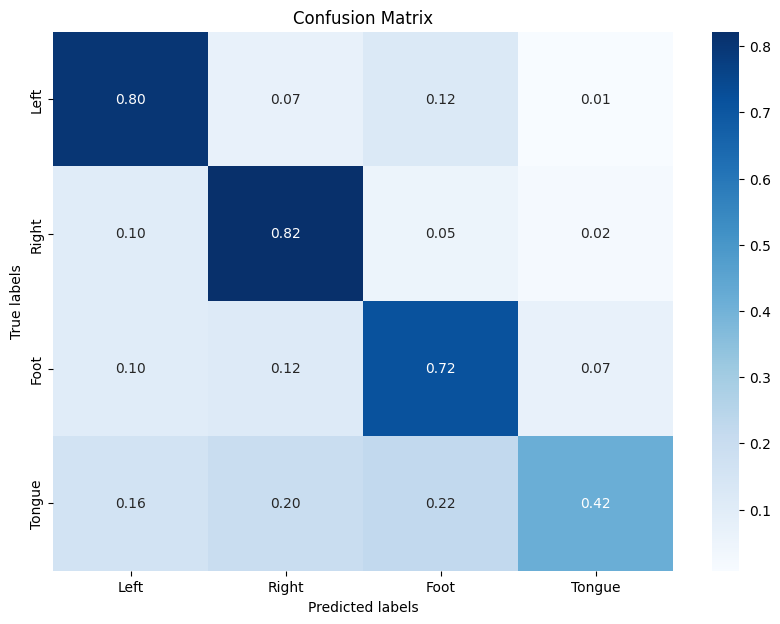

In [18]:
classes_list = ['Left', 'Right', 'Foot', 'Tongue']
eval_model_val = EvalModel(trained_eegnet_model_val)
test_accuracy_val = eval_model_val.test_model(test_dataset)
print(f"Test accuracy with validation: {test_accuracy_val:.2f}%")
eval_model_val.plot_confusion_matrix(test_dataset, classes_list)

# Val X

In [ ]:
class TrainModel():
    def __init__(self,):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train_model(self, model, train_dataset, learning_rate=0.001, batch_size=64, epochs=500):
        model = model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # 러닝 커브를 위한 리스트들
        train_losses = []
        train_accuracies = []
        epochs_list = []
        highest_train_accuracy = 0.0

        # 실시간 플롯 설정
        plt.ion()
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct / total
            
            if epoch_accuracy > highest_train_accuracy:
                highest_train_accuracy = epoch_accuracy
            
            # 리스트에 추가
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)
            epochs_list.append(epoch + 1)
            
            # 10 에포크마다 출력 및 플롯 업데이트
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}")
                print(f"  Train - Loss: {epoch_loss:.4f}, Accuracy: {(epoch_accuracy*100):.2f}%")
                print("-" * 60)
                
                # 플롯 업데이트
                ax1.clear()
                ax2.clear()
                
                # Loss 플롯
                ax1.plot(epochs_list, train_losses, 'b-', label='Train Loss', linewidth=2)
                ax1.set_xlabel('Epoch')
                ax1.set_ylabel('Loss')
                ax1.set_title('Training Loss')
                ax1.legend()
                ax1.grid(True, alpha=0.3)
                
                # Accuracy 플롯
                ax2.plot(epochs_list, [acc*100 for acc in train_accuracies], 'b-', label='Train Accuracy', linewidth=2)
                ax2.set_xlabel('Epoch')
                ax2.set_ylabel('Accuracy (%)')
                ax2.set_title('Training Accuracy')
                ax2.legend()
                ax2.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.draw()
                plt.pause(0.01)

        plt.ioff()
        plt.show()
        
        print("\n" + "="*60)
        print("TRAINING COMPLETED!")
        print("="*60)
        print(f"Highest Train Accuracy: {highest_train_accuracy*100:.2f}%")
        print(f"Final Train Loss: {train_losses[-1]:.4f}")

        # 모델 저장
        torch.save(model.state_dict(), 'eegnet_model.pth')
        
        # 결과를 딕셔너리로 반환
        training_history = {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'epochs': epochs_list
        }
        
        return model, training_history

# val X

In [ ]:
eegnet_model = EEGNetModel().to(device)

# Training Hyperparameters
EPOCHS = 500
BATCH_SIZE = 64
LEARNING_RATE = 0.001

trainer = TrainModel()
trained_eegnet_model, history = trainer.train_model(
    eegnet_model, 
    train_dataset, 
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS
)

torch.save(trained_eegnet_model.state_dict(), 'eegnet_model.pth')

# 최종 러닝 커브 저장
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history['epochs'], history['train_losses'], 'b-', label='Train Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['epochs'], [acc*100 for acc in history['train_accuracies']], 'b-', label='Train Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Evaluating Model

In [ ]:

classes_list = ['Left', 'Right', 'Foot', 'Tongue']
eval_model = EvalModel(trained_eegnet_model)
test_accuracy = eval_model.test_model(test_dataset)
eval_model.plot_confusion_matrix(test_dataset, classes_list)